This one is getting ./AS13_reduc/data/AS13_stgdir_labelGeneric.csv

In [1]:
# run this first cell and then do "restart and run all" from the run menu
!pip install -U accelerate

In [2]:
##### CONFIG ####

dataset_name = "AS13_stgdir_labelGeneric"

model_dict = {1: "camembert-base", 2: "cmarkea/distilcamembert-base", 3: "bert-base-multilingual-cased", 4: "distilbert-base-multilingual-cased",
              5: "bert-base-multilingual-uncased", 6: "distilbert-base-multilingual-uncased"}

model_key = 3
model_ckpt = model_dict[model_key]
fraction_kept = 100 # can only be 100, 50, 25, 10
run_number = 1

batch_size = 16
max_epochs = 10
assert not(fraction_kept < 50 and max_epochs < 10)

use_drive = False
save_model = False

# output dir format (below)
#output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}"

In [3]:
assert fraction_kept in [100*x for x in (1, 0.5, 0.25, 0.1)]
assert run_number in (1,2,3)

In [4]:
# fraction kept to color map
clrmap_dict = {100: "Greens", 50: "Blues", 25: "Purples", 10: "Oranges"}
assert fraction_kept in clrmap_dict

In [5]:
!python --version

Python 3.10.12


In [6]:
!mkdir data

In [7]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [8]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [9]:
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [10]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00


In [11]:
import os

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import torch

In [12]:
from sklearn.metrics import classification_report

J'ai téléversé les données sur mon serveur

In [13]:
![[ ! -d data ]] && mkdir data || echo "data directory exists"
#![[ ! -f data/AS13_stgdir_clean.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_clean.csv || echo "dataset already downloaded"
![[ ! -f data/AS13_stgdir_labelGeneric.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv || echo "dataset already downloaded"

data directory exists
--2023-10-17 23:28:25--  https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv
Resolving prf1.org (prf1.org)... 85.214.103.246
Connecting to prf1.org (prf1.org)|85.214.103.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1017742 (994K) [text/csv]
Saving to: ‘data/AS13_stgdir_labelGeneric.csv’

AS13_stgdir_labelGe 100%[===================>] 993.89K  1.36MB/s    in 0.7s    

2023-10-17 23:28:26 (1.36 MB/s) - ‘data/AS13_stgdir_labelGeneric.csv’ saved [1017742/1017742]



Recette pour éléchargement fichiers qui sont sur Drive sur la session Colab (sans monter le Drive) (pas nécessaire ici mais comme idée pour d'autres fichiers).
C'est un fichier quelconque non relié à la tâche qui a été utilisé pour tester.

In [14]:
mydf = "data/AS13_stgdir_labelGeneric.csv"

In [15]:
labelCol = 'labelGeneric'

In [16]:
import pandas as pd
AS13_df = pd.read_csv(mydf, sep="|", dtype={'description': 'object',
                                            labelCol: 'category'})

In [17]:
AS13_df = AS13_df.drop_duplicates()
AS13_df = AS13_df.dropna(how='any')
AS13_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 0 to 25821
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   description   14613 non-null  object  
 1   labelGeneric  14613 non-null  category
dtypes: category(1), object(1)
memory usage: 243.2+ KB


In [18]:
df = AS13_df

In [19]:
df['labelGeneric'].value_counts()

music          2863
action         2467
toward         2144
exit           1295
object         1130
setting         982
delivery        962
entrance        646
movement        583
interaction     565
narration       554
aggression      350
aparte           72
Name: labelGeneric, dtype: int64

In [20]:
# Liste de classes et ajout d'un identifiant numérique pour chaque classe
class_names = sorted(AS13_df[labelCol].unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}

In [21]:
#class_names, label2id, id2label

In [22]:
# Paramètres

#batch_size = 32 # orig was 64 but I'm going down given CUDA OutOfMemory error
batch_size = 16 # for camembert-base, trying 16
# Proportion des données qui sera utilisée
scale = 0.2 # this is not used anywhere, can we remove it?

In [23]:
# nv dataFrame
data_df = pd.DataFrame()
data_df['text'] = AS13_df.description
# La classe cible est la région (province) sous forme d'identifiant numérique
data_df['label'] = AS13_df[labelCol].map(label2id)

In [24]:
data_df = data_df.reset_index(drop=True)

In [25]:
# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
stgtype_features = Features({'text': Value('string'),
                              'label': ClassLabel(names=class_names)})
data = Dataset.from_pandas(data_df, features=stgtype_features)


In [26]:
# Découpage en (train + validation) (this part will be reduced to 50%, 25% and so on to compare quality) et (test).
# The test part is supposed to always stay the same size and with the same examples

In [27]:
TRAIN_FULL, TRAIN_REDUCED = False, False
size_to_exclude = (100 - fraction_kept)/100
if size_to_exclude == 0:
  TRAIN_FULL = True
  print("FULL TRAIN")
else:
  TRAIN_REDUCED = True
  print(f"REDUCED TRAIN, KEEPING {fraction_kept}%")

FULL TRAIN


In [28]:
print(f"SIZE TO EXCLUDE IS {size_to_exclude}")

SIZE TO EXCLUDE IS 0.0


In [29]:
if TRAIN_REDUCED:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_reduced = trainvalid_test['train'].train_test_split(test_size=size_to_exclude, shuffle=True, seed=12)
  trainvalid_reduced_trainvalid = trainvalid_reduced['train'].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_reduced_trainvalid["train"],
                         "valid": trainvalid_reduced_trainvalid["test"],
                         "test": trainvalid_test["test"]})
elif TRAIN_FULL:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_trainvalid = trainvalid_test["train"].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_trainvalid["train"],
                         "valid": trainvalid_trainvalid["test"],
                         "test": trainvalid_test["test"]})

In [30]:
data = dataset

In [31]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9352
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2338
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2923
    })
})

In [32]:
#steps = (epoch * examples)/batch size
total_steps = (6 * len(df))/16
total_steps

5479.875

In [33]:
# this is unused unless use steps as strategy in training args
epoch_size = len(data['train'])/batch_size

In [34]:
print(f"EPOCH SIZE IS: {epoch_size}")

EPOCH SIZE IS: 584.5


When needed, export the dataset to verify later that it's indeed the same for all experiments

In [35]:
if use_drive:
  from google.colab import drive
  drive.mount("/content/drive")
  dataset_bkps = "/content/drive/MyDrive/___wv/datasets"
  current_dataset = "AS13_stgdir_labelGeneric_trainvalid_retest_uncased_25_pr_2"
  os.mkdir(os.path.join(dataset_bkps, current_dataset))
  for split, split_data in data.items():
    split_data.to_csv(Path(dataset_bkps) / current_dataset / f"{current_dataset}-{split}.csv")
    print(f"!head -n5 {split_path_str}")

In [36]:
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-train.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-valid.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-test.csv

In [37]:
# Chargement du tokéniseur pré-entraîné correspondant au modèle utilisé
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [38]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [39]:
%pdb

Automatic pdb calling has been turned ON


In [40]:
# Tokenisation de la totalité des données : chaque unité est remplacée par un identifiant numérique
tokenized_data = data.map(preprocess_function, batched=True, batch_size=None)

Map:   0%|          | 0/9352 [00:00<?, ? examples/s]

Map:   0%|          | 0/2338 [00:00<?, ? examples/s]

Map:   0%|          | 0/2923 [00:00<?, ? examples/s]

In [41]:
# Taille du vocabulaire
tokenizer.vocab_size

119547

In [42]:
# Taille de contexte maximum
tokenizer.model_max_length

512

In [43]:
accuracy = evaluate.load("accuracy")

In [44]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=len(class_names), id2label=id2label, label2id=label2id
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
batch_size=16

In [47]:
from math import ceil
intended_eval_steps = ceil(len(data['train'])/batch_size)

In [48]:
# was recommended at https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances, but seems
# to no longer be necessary
# on 'eval_loss' as metric https://discuss.huggingface.co/t/early-stopping-training-using-validation-loss-as-the-metric-for-best-model/31378
if False:
  training_args = TrainingArguments(
      output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}",
      learning_rate=2e-5,
      num_train_epochs=max_epochs,
      evaluation_strategy=IntervalStrategy.STEPS,
      eval_steps = intended_eval_steps,
      save_steps = intended_eval_steps,
      save_total_limit = 3,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      weight_decay=0.01,
      save_strategy=IntervalStrategy.STEPS,
      load_best_model_at_end=True,
      metric_for_best_model='eval_loss',
  )

In [49]:
training_args = TrainingArguments(
    output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=max_epochs,
    weight_decay=0.01,
    save_total_limit = 3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

Now we use train et validation for the fine-tuning. We'll only use test to test the model after fine-tuning

In [50]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [51]:
batch_size

16

In [52]:
print(f"## FINE TUNING A {model_ckpt} MODEL ##")

## FINE TUNING A bert-base-multilingual-cased MODEL ##


In [53]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.067200,0.595833,0.830624
2,0.527100,0.566747,0.848161
3,0.381400,0.587107,0.857571
4,0.280200,0.576267,0.866553
5,0.252800,0.644358,0.867408


TrainOutput(global_step=2925, training_loss=0.45712281577607505, metrics={'train_runtime': 1559.0638, 'train_samples_per_second': 59.985, 'train_steps_per_second': 3.752, 'total_flos': 1.230428805623808e+16, 'train_loss': 0.45712281577607505, 'epoch': 5.0})

In [54]:
preds_output = trainer.predict(tokenized_data['test'])

In [55]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [56]:
y_test = tokenized_data['test']['label']

In [57]:
labels = tokenized_data['test'].features['label'].names

In [58]:
# fraction kept to color map
clrmap_dict = {100: "Greens", 50: "Blues", 25: "Purples", 10: "Oranges"}

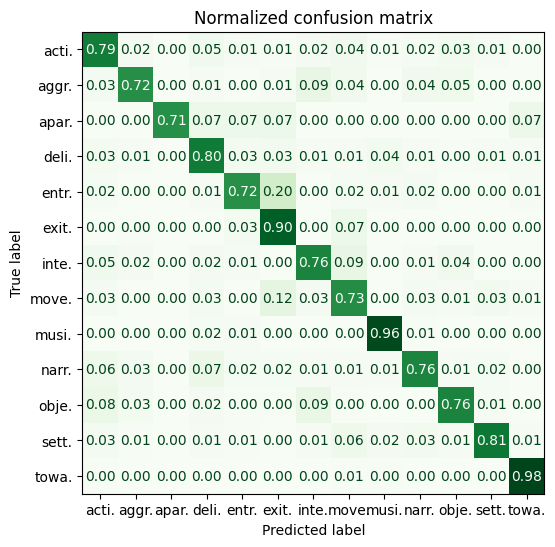

In [59]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    labels_for_fig = [l[0:4]+'.' for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
    disp.plot(cmap=clrmap_dict[fraction_kept], values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_test, labels)

In [60]:
print("Classification report:\n\n{}".format(classification_report(y_test, y_preds)))

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       486
           1       0.68      0.72      0.70        75
           2       1.00      0.71      0.83        14
           3       0.76      0.80      0.78       213
           4       0.77      0.72      0.74       128
           5       0.80      0.90      0.84       242
           6       0.64      0.76      0.70       102
           7       0.56      0.73      0.63       119
           8       0.97      0.96      0.96       577
           9       0.74      0.76      0.75       120
          10       0.84      0.76      0.80       208
          11       0.91      0.81      0.86       190
          12       0.98      0.98      0.98       449

    accuracy                           0.85      2923
   macro avg       0.81      0.80      0.80      2923
weighted avg       0.86      0.85      0.85      2923



In [61]:
for i in range(13):print(i, id2label[i], end=" ")

0 action 1 aggression 2 aparte 3 delivery 4 entrance 5 exit 6 interaction 7 movement 8 music 9 narration 10 object 11 setting 12 toward 

In [62]:
if save_model:
  assert use_drive is True
  model.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")
  tokenizer.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")